<a href="https://colab.research.google.com/github/Usama-zia/MonReader/blob/master/notebooks/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries and Load Dataset

In [ ]:
#Importing Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil
import os

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Activation
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.initializers import he_uniform


!pip uninstall gdown -y && pip install gdown
!gdown -V
print(tf.__version__)

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
gdown 4.5.4 at /usr/local/lib/python3.7/dist-packages
2.9.2


Dataset will be downloaded using gdwon a python pakacge used to download large files from google drive,its link can be found [here](https://github.com/wkentaro/gdown).

In [ ]:
#downloading the dataset
import gdown
!python3 -m gdown.cli "https://drive.google.com/u/0/uc?id=1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm&confirm=t"

Downloading...
From: https://drive.google.com/u/0/uc?id=1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm&confirm=t
To: /content/images.zip
100% 940M/940M [00:09<00:00, 98.6MB/s]


Dataset is now downloaded as zip file next step will be to use shutil to unzip it.

In [ ]:
#Unzip dataset
dataset = '/content/images.zip'
shutil.unpack_archive(dataset)

This function in next cell provides F1 Score to determine the overall performance of models used for training and testing the dataset. This  code is written following the article found [here](https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras).

In [ ]:
#custom f1_score
def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Dataset is loaded, batch size is provided as 32. original images dimensions are 
1920x1080, however to decrease training time, dimensions have been reduced to 640x360. Train, validation, and test split are done with validation having 20% of training data.

In [ ]:
batch_size = 32
img_height = 320
img_width = 180

train_images = tf.keras.utils.image_dataset_from_directory(
  '/content/images/training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_images =  tf.keras.utils.image_dataset_from_directory(
  '/content/images/training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_images = tf.keras.utils.image_dataset_from_directory(
    '/content/images/testing',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [ ]:
# check class names
class_names = train_images.class_names
print(class_names)

['flip', 'notflip']


## Training
Three diffrent models will be used to train and test the dataset. Depending on the performance one model will be selected for production. The custom model will be used as baseline for comparison.

1.   MobileNetV2
2.   InceptionV3
3.   Custom CNN

For optimization all models will use "Adam" optimizer will be used, with the learning rate of 0.001.


##Training dataset with MobileNetV2

In [ ]:
mobilenetv2_model = Sequential()
img_height = 320
img_width = 180
base_model = MobileNetV2(include_top=False,
    weights = 'imagenet',
    input_shape=(img_height, img_width, 3),
    pooling='avg')

base_model.trainable = False

mobilenetv2_model.add(base_model)
mobilenetv2_model.add(Flatten())
mobilenetv2_model.add(Dense(512, activation='relu'))
mobilenetv2_model.add(Dense(1, activation='sigmoid'))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenetv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,914,369
Trainable params: 656,385
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
mobilenetv2_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_score])

In [ ]:
hist = mobilenetv2_model.fit(train_images,validation_data=val_images,epochs=20)

Epoch 1/20
60/60 [==============================] - 119s 2s/step - loss: 0.6231 - accuracy: 0.6891 - f1_score: 0.6527 - val_loss: 0.4172 - val_accuracy: 0.8556 - val_f1_score: 0.8426
Epoch 2/20
60/60 [==============================] - 108s 2s/step - loss: 0.3599 - accuracy: 0.8584 - f1_score: 0.8614 - val_loss: 0.2900 - val_accuracy: 0.9038 - val_f1_score: 0.9058
Epoch 3/20
60/60 [==============================] - 112s 2s/step - loss: 0.2636 - accuracy: 0.9086 - f1_score: 0.9115 - val_loss: 0.2143 - val_accuracy: 0.9331 - val_f1_score: 0.9326
Epoch 4/20
60/60 [==============================] - 107s 2s/step - loss: 0.1844 - accuracy: 0.9493 - f1_score: 0.9522 - val_loss: 0.1771 - val_accuracy: 0.9477 - val_f1_score: 0.9467
Epoch 5/20
60/60 [==============================] - 107s 2s/step - loss: 0.1541 - accuracy: 0.9582 - f1_score: 0.9569 - val_loss: 0.1487 - val_accuracy: 0.9603 - val_f1_score: 0.9611
Epoch 6/20
60/60 [==============================] - 106s 2s/step - loss: 0.1184 - acc

In [ ]:
mobilenetv2_model.evaluate(test_images)

19/19 [==============================] - 27s 1s/step - loss: 0.0560 - accuracy: 0.9782 - f1_score: 0.9762


[0.055991340428590775, 0.9782244563102722, 0.9762470722198486]

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


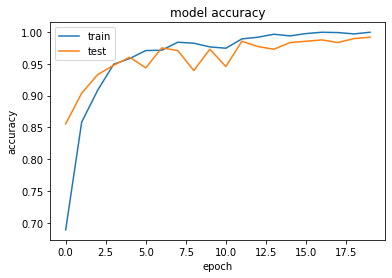

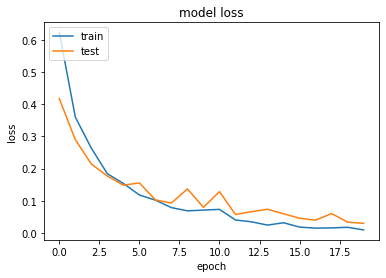

In [ ]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

MobileNetV2 performs well with test set accuray, and F1 Score of 97.82% and 97.62%.

##training dataset with InceptionV3

In [ ]:
inceptionv3_model = Sequential()
img_height = 320
img_width = 180
base_model = InceptionV3(include_top=False,
    input_shape=(img_height, img_width, 3),
    weights = 'imagenet',
    pooling='avg')

base_model.trainable = False

inceptionv3_model.add(base_model)
inceptionv3_model.add(Flatten())
inceptionv3_model.add(Dense(512, activation='relu'))
inceptionv3_model.add(Dense(1, activation='sigmoid'))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
inceptionv3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 22,852,385
Trainable params: 1,049,601
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
inceptionv3_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_score])

In [ ]:
hist_inception = inceptionv3_model.fit(train_images,validation_data=val_images,epochs=30)

Epoch 1/30
60/60 [==============================] - 327s 5s/step - loss: 10.9881 - accuracy: 0.6296 - f1_score: 0.5697 - val_loss: 1.4790 - val_accuracy: 0.6778 - val_f1_score: 0.5966
Epoch 2/30
60/60 [==============================] - 318s 5s/step - loss: 0.7462 - accuracy: 0.7853 - f1_score: 0.7697 - val_loss: 0.3987 - val_accuracy: 0.8536 - val_f1_score: 0.8526
Epoch 3/30
60/60 [==============================] - 316s 5s/step - loss: 0.4934 - accuracy: 0.8229 - f1_score: 0.8107 - val_loss: 1.9090 - val_accuracy: 0.6025 - val_f1_score: 0.7163
Epoch 4/30
60/60 [==============================] - 329s 5s/step - loss: 0.6325 - accuracy: 0.8030 - f1_score: 0.7939 - val_loss: 0.3588 - val_accuracy: 0.8745 - val_f1_score: 0.8639
Epoch 5/30
60/60 [==============================] - 312s 5s/step - loss: 1.6825 - accuracy: 0.7524 - f1_score: 0.6950 - val_loss: 0.7670 - val_accuracy: 0.7720 - val_f1_score: 0.7250
Epoch 6/30
60/60 [==============================] - 316s 5s/step - loss: 0.3447 - ac

In [ ]:
inceptionv3_model.evaluate(test_images)

19/19 [==============================] - 80s 4s/step - loss: 0.1647 - accuracy: 0.9363 - f1_score: 0.9299


[0.16466139256954193, 0.9363484382629395, 0.9298736453056335]

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


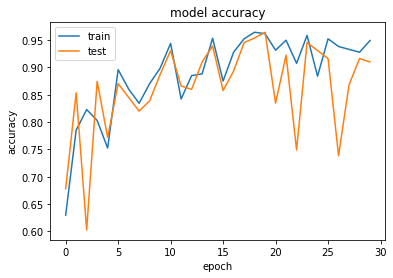

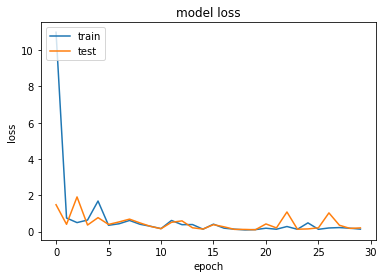

In [ ]:
print(hist_inception.history.keys())
# summarize history for accuracy
plt.plot(hist_inception.history['accuracy'])
plt.plot(hist_inception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_inception.history['loss'])
plt.plot(hist_inception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

InceptionV3's performance is slighltly less compare to MobileNetV2 model with the accuracy and F1 Score of 93.63% and 92.99% respectively. 

## Custom CNN

Custom CNN has four total layers after the input layer with 1st three being convolution layers and 4th being the fully connected layer.

In [ ]:
def custom_cnn(input_size = (320, 180, 3)):
  inputs = Input(input_size)
  # 1st  layer
  image_feat = Conv2D(16, (7, 7), strides = (2, 2), kernel_initializer = he_uniform())(inputs)
  image_feat = BatchNormalization(axis = 3)(image_feat)
  image_feat = Activation('relu')(image_feat)
  image_feat = MaxPooling2D((3, 3), strides=(2, 2))(image_feat)
  # 2nd layer
  image_feat = Conv2D(64, (5, 5), strides = (2, 2), kernel_initializer = he_uniform())(image_feat)
  image_feat = BatchNormalization(axis = 3)(image_feat)
  image_feat = Activation('relu')(image_feat)
  image_feat = MaxPooling2D((2, 2), strides=(2, 2))(image_feat)
  # 3rd layer
  image_feat = Conv2D(256, (3, 3), strides = (1, 1), kernel_initializer = he_uniform())(image_feat)
  image_feat = BatchNormalization(axis = 3)(image_feat)
  image_feat = Activation('relu')(image_feat)
  image_feat = MaxPooling2D((2, 2), strides=(2, 2))(image_feat)
  # 4th layer,final layer (fully connected layer)
  image_feat = Flatten()(image_feat)
  image_feat = Dense(256, activation='relu', kernel_initializer = he_uniform())(image_feat)
  image_feat = Dense(32, activation='relu', kernel_initializer = he_uniform())(image_feat)
  outputs = Dense(1, activation='sigmoid', kernel_initializer = he_uniform())(image_feat)
  
  model = Model(inputs = inputs, outputs = outputs)
  
  return model

In [ ]:
# Initialize the model
custom_model = custom_cnn((320, 180, 3))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1_score])
# Print model summary
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 157, 87, 16)       2368      
                                                                 
 batch_normalization (BatchN  (None, 157, 87, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 157, 87, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 20, 64)        25664 

In [ ]:
hist_custom = custom_model.fit(train_images,validation_data=val_images,epochs=10)

Epoch 1/10
60/60 [==============================] - 80s 1s/step - loss: 0.5688 - accuracy: 0.8135 - f1_score: 0.7883 - val_loss: 5.0501 - val_accuracy: 0.5105 - val_f1_score: 0.6713
Epoch 2/10
60/60 [==============================] - 72s 1s/step - loss: 0.1117 - accuracy: 0.9556 - f1_score: 0.9559 - val_loss: 4.2275 - val_accuracy: 0.5146 - val_f1_score: 0.6741
Epoch 3/10
60/60 [==============================] - 72s 1s/step - loss: 0.0559 - accuracy: 0.9838 - f1_score: 0.9829 - val_loss: 3.3473 - val_accuracy: 0.5418 - val_f1_score: 0.6865
Epoch 4/10
60/60 [==============================] - 72s 1s/step - loss: 0.0580 - accuracy: 0.9791 - f1_score: 0.9797 - val_loss: 2.4667 - val_accuracy: 0.6130 - val_f1_score: 0.7188
Epoch 5/10
60/60 [==============================] - 73s 1s/step - loss: 0.0312 - accuracy: 0.9880 - f1_score: 0.9879 - val_loss: 0.3241 - val_accuracy: 0.8933 - val_f1_score: 0.9045
Epoch 6/10
60/60 [==============================] - 74s 1s/step - loss: 0.0036 - accuracy:

In [ ]:
custom_model.evaluate(test_images)

19/19 [==============================] - 9s 352ms/step - loss: 0.0124 - accuracy: 0.9950 - f1_score: 0.9944


[0.012374429032206535, 0.9949748516082764, 0.9944398999214172]

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


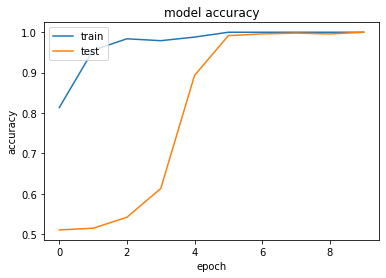

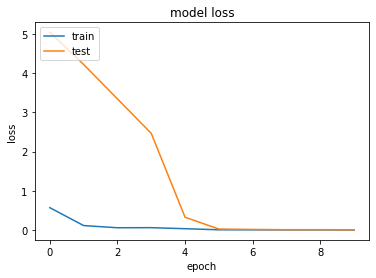

In [ ]:
print(hist_custom.history.keys())
# summarize history for accuracy
plt.plot(hist_custom.history['accuracy'])
plt.plot(hist_custom.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_custom.history['loss'])
plt.plot(hist_custom.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Custom CNN is overfitting on dataset, however given time further modifications could be made to optimize the model for this dataset.

##Conclusion

MobileNetV2 has performed very vell with F1 Score of 97.62%, comapred to InceptionV3 and Custom CNN which is overfitting on the dataset. MobileNetV2 is perpose built for embedded and mobile applications, so its the right fit a mobile application, hence MobileNetV2 will be choosen for this project. 